### Original code during the interview

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [2]:
class KMeans:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
    
    def get_centroids(self):
        return self.centroids
    
    def get_groups(self):
        return self.groups
    
    def fit(self, data, num_iterations):
        self.centroids = data[np.random.choice(len(data), self.num_clusters, replace=False)]
        distances = np.zeros((self.num_clusters, len(data)))
        
        for iteration in range(num_iterations):
            # calculate the euclidean distances btw the centroids and data
            for (centroid_index, centroid) in enumerate(self.centroids):
                distance = np.linalg.norm(centroid-data, axis=-1)
                distances[centroid_index] = distance

            # assign the groups and relocate the centroids
            self.groups = np.argmin(distances, axis=0)  # group for each data
            
            for g in range(self.num_clusters):
                group_points = data[self.groups==g]  # data points in the group
                self.centroids[g] = np.mean(group_points, axis=0)

In [3]:
data, _ = make_classification(n_samples=500, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class=1)

In [4]:
model = KMeans(num_clusters=3)
model.fit(data, num_iterations=10)
centroids = model.get_centroids()
groups = model.get_groups()

In [5]:
def draw_graph(group_colors, data, groups, centroids):
    colors = [group_colors[g] for g in groups]
    plt.scatter(data[:, 0], data[:, 1], color=colors, alpha=0.1)
    plt.scatter(centroids[:, 0], centroids[:, 1], color=group_colors)
    plt.show()

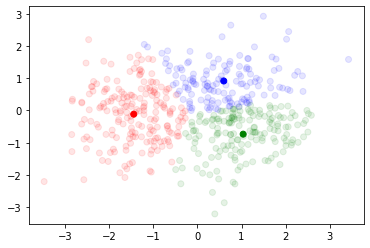

In [6]:
group_colors = ['green', 'blue', 'red']
draw_graph(group_colors, data, groups, centroids)

### New code
Let's build a new library for KMeans

What's new?
1. Run multiple times with different initialisations to find the best centroids
2. Early stopping when the centroids don't move farther than the threshold

Possible improvements
- Can consider using gradient descent to minimise the loss function
- K-Means++ to start with better initialisations

In [7]:
class NewKMeans:
    def __init__(self, num_groups):
        self.num_groups = num_groups
        self.groups = None
        self.centroids = None
        
    def get_centroids(self):
        return self.centroids
    
    def get_groups(self):
        return self.groups
    
    def compute_loss(self, data, centroids, groups):
        """
        :return: Mean of euclidean distances between centroids and their group points
        """
        loss = 0
        for (group, centroid) in enumerate(centroids):
            group_points = data[groups == group]
            loss += np.linalg.norm(centroid-group_points)
        loss /= len(data)
        return loss
    
    def run_kmeans_once(self, data, centroids_shift_threshold, verbose):
        """
        :param data: Data to clustet
        :param centroids_delta_threshold: Minimum threshold of shift of centroids
        :param verbose: Whether to print when the early stopping occured
        
        :return: New centroids, group labels for each data, loss
        """
        centroids = data[np.random.choice(len(data), self.num_groups, replace=False)]
        distances = np.zeros((self.num_groups, len(data)))
        
        centroids_shift = np.inf  # mean changes of the centroids' positions
        iteration = 0  # number of iterations so far

        while (centroids_shift_threshold < centroids_shift):
            centroids_shift = 0
            # calculate the euclidean distances btw the centroids and data
            for (group, centroid) in enumerate(centroids):
                distance = np.linalg.norm(centroid-data, axis=-1)
                distances[group] = distance

            # assign the groups and relocate the centroids
            groups = np.argmin(distances, axis=0)  # group for each data

            for group in range(self.num_groups):
                group_points = data[groups==group]
                new_centroid = np.mean(group_points, axis=0)
                centroids_shift += np.linalg.norm(new_centroid-centroids[group])
                centroids[group] = new_centroid
            centroids_shift /= self.num_groups

            iteration += 1
            
        loss = self.compute_loss(data, centroids, groups)

        if verbose:
            print("Earlystopped at ", iteration, "th iteration / Loss: ", loss)
            
        return centroids, groups, loss
    
    def fit(self,
            data,
            num_inits=10,
            centroids_shift_threshold=0.01,
            verbose=False):
        """
        Run kmeans `num_inits` number of times to find the best centroids with the smallest loss
        
        :param data: Dataset to cluster
        :param num_inits: Number of times to experiment with different centroids
        :param centroid_threshold: Minimum threshold of shift of centroids
        :param verbose: Whether to print when the early stopping occured
        """
        
        # returned values of each initialisation
        loss_history = []
        groups_history = []  # 
        centroids_history = []
        
        for _ in range(num_inits):
            centroids, groups, loss = self.run_kmeans_once(data, centroids_shift_threshold, verbose)
            groups_history += groups,
            centroids_history += centroids,
            loss_history += loss,
            
        # update groups and centroids with the smallest loss
        best_index = np.argmin(loss_history)
        self.groups = groups_history[best_index]
        self.centroids = centroids_history[best_index]

In [8]:
new_model = NewKMeans(num_groups=3)
new_model.fit(data, num_inits=5, verbose=True)
centroids = new_model.get_centroids()
groups = new_model.get_groups()

Earlystopped at  6 th iteration / Loss:  0.07973131861945225
Earlystopped at  8 th iteration / Loss:  0.07892435276863581
Earlystopped at  9 th iteration / Loss:  0.08123467396516418
Earlystopped at  10 th iteration / Loss:  0.07906311970960908
Earlystopped at  15 th iteration / Loss:  0.07985845790581146


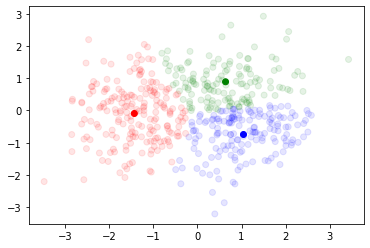

In [9]:
draw_graph(group_colors, data, groups, centroids)